# Confidence Threshold Analysis (Enhanced Retrieval)

This notebook determines an appropriate confidence threshold for the FAQ
retrieval system using **enhanced evaluation results** after multilingual
question augmentation.

The goal is to balance:
- **Accuracy**: correctness when answering confidently
- **Coverage**: how often the system provides a confident answer

The chosen threshold will be applied in the application to trigger
a fallback UX when confidence is low, ensuring reliable behavior
across both English and Macedonian queries.

In [1]:
import pandas as pd
import numpy as np

In [2]:
RESULTS_PATH = "results/enhanced_results.csv"

df = pd.read_csv(RESULTS_PATH)
df

,query,language,expected_faq_id,retrieved_ids,rank_of_expected,top1_correct,top3_correct,confidence
0,"I can't log into my account, how do I reset my...",en,reset_password_q_en,"['reset_password_q_en', 'forgot_password_login...",1,True,True,0.681
1,Forgot my password and now I'm locked out,en,forgot_password_login_q_en,"['forgot_password_login_q_en', 'reset_password...",1,True,True,0.648
2,The password reset email never arrives,en,password_reset_email_missing_q_en,"['password_reset_email_missing_q_en', 'reset_p...",1,True,True,0.590
3,How can I update the email linked to my account?,en,change_email_q_en,"['change_email_q_en', 'update_billing_q_en', '...",1,True,True,0.485
4,Where can I change my credit card details?,en,update_billing_q_en,"['change_email_q_en', 'update_billing_q_en', '...",2,False,True,0.151
5,My card was charged twice this month,en,double_charge_q_en,"['double_charge_q_en', 'update_billing_q_en', ...",1,True,True,0.752
6,I want to stop my subscription,en,cancel_subscription_q_en,"['cancel_subscription_q_en', 'upgrade_subscrip...",1,True,True,0.708
7,"If I cancel my plan, will I get my money back?",en,refund_policy_q_en,"['refund_policy_q_en', 'cancel_subscription_q_...",1,True,True,0.659
8,How do I download previous invoices?,en,download_invoices_q_en,"['download_invoices_q_en', 'update_billing_q_e...",1,True,True,0.807
9,Which credit cards can I use to pay?,en,payment_methods_q_en,"['payment_methods_q_en', 'update_billing_q_en'...",1,True,True,0.413


In [3]:
df.groupby("top1_correct")["confidence"].describe()

,count,mean,std,min,25%,50%,75%,max
top1_correct,,,,,,,,
False,3.0,0.583667,0.374834,0.151,0.4705,0.790,0.800,0.81
True,29.0,0.696207,0.138395,0.413,0.6330,0.683,0.767,1.00


In [4]:
thresholds = np.arange(0.15, 0.81, 0.05)
thresholds

array([0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65,
       0.7 , 0.75, 0.8 ])

In [5]:
rows = []

for t in thresholds:
    covered = df[df["confidence"] >= t]

    coverage = len(covered) / len(df)

    if len(covered) > 0:
        accuracy = covered["top1_correct"].mean()
    else:
        accuracy = np.nan

    rows.append({
        "threshold": round(float(t), 2),
        "coverage": round(float(coverage), 3),
        "accuracy": round(float(accuracy), 3) if not np.isnan(accuracy) else None,
        "num_covered": len(covered)
    })

threshold_df = pd.DataFrame(rows)
threshold_df

,threshold,coverage,accuracy,num_covered
0,0.15,1.000,0.906,32
1,0.20,0.969,0.935,31
2,0.25,0.969,0.935,31
3,0.30,0.969,0.935,31
4,0.35,0.969,0.935,31
5,0.40,0.969,0.935,31
6,0.45,0.938,0.933,30
7,0.50,0.875,0.929,28
8,0.55,0.812,0.923,26
9,0.60,0.781,0.920,25


<Axes: title={'center': 'Accuracy vs Coverage by Confidence Threshold'}, xlabel='threshold'>

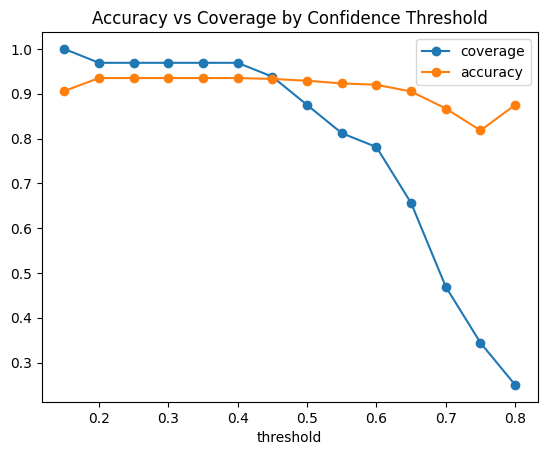

In [6]:
threshold_df.plot(
    x="threshold",
    y=["coverage", "accuracy"],
    marker="o",
    title="Accuracy vs Coverage by Confidence Threshold"
)

In [7]:
lang_rows = []

for t in thresholds:
    for lang in ["en", "mk"]:
        subset = df[(df["confidence"] >= t) & (df["language"] == lang)]

        coverage = len(subset) / len(df[df["language"] == lang])
        accuracy = subset["top1_correct"].mean() if len(subset) > 0 else None

        lang_rows.append({
            "threshold": round(float(t), 2),
            "language": lang,
            "coverage": round(float(coverage), 3),
            "accuracy": round(float(accuracy), 3) if accuracy is not None else None
        })

lang_threshold_df = pd.DataFrame(lang_rows)
lang_threshold_df

,threshold,language,coverage,accuracy
0,0.15,en,1.000,0.950
1,0.15,mk,1.000,0.833
2,0.20,en,0.950,1.000
3,0.20,mk,1.000,0.833
4,0.25,en,0.950,1.000
5,0.25,mk,1.000,0.833
6,0.30,en,0.950,1.000
7,0.30,mk,1.000,0.833
8,0.35,en,0.950,1.000
9,0.35,mk,1.000,0.833


## Threshold Selection

Based on the accuracy–coverage tradeoff observed in the enhanced evaluation, threshold **0.65** achieves a strong balance between accuracy and coverage

At this threshold:
- Accuracy remains above **90%**
- Coverage remains acceptable for user experience
- Confidence filtering is stricter than baseline without being overly aggressive

**Chosen threshold: 0.7**